In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

2021.07.19

# 计算位势高度的纬向、时间平均

采用和此前NCL脚本相似的方式读入数据，即ERA5I从筛选的ERA5I读入，VR\RCM数据从diag中选取（不太适合进行垂直剖面的绘制）

In [2]:

filename_era5i = "ydaymean_hgt_daily.nc"
filename_vr     = "ydaymean_hgt_VR_98-17.nc"
filename_rcm    = "ydaymean_hgt_RCM_98-17.nc"

ds_or = {}
dir_in = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/hgt/"
ds_or['era5i']  = xr.open_dataset(dir_in + filename_era5i)
dir_in = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/diag_daily_selected/hgt/"
ds_or['vr']     = xr.open_dataset(dir_in + filename_vr)
dir_in = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/diag_daily_selected/hgt/"
ds_or['rcm']    = xr.open_dataset(dir_in + filename_rcm  )
# 提取变量
var = {}
var['era5i'] = ds_or['era5i']['hgt'].sel(level=850)
var['vr'] = ds_or['vr']['height_850hPa']
var['rcm'] = ds_or['rcm']['height_850hPa']
# change coords
var_list = ['era5i', 'vr', 'rcm']
for i in var_list:
    rename_dict = dict(zip(var[i].coords.keys(), var['era5i'].coords.keys()))
    # show converting coords
    for rename_i in rename_dict:
        print(rename_i + " -----converting to----- " + rename_dict[rename_i])

    var[i] = var[i].rename(rename_dict)
    var[i]._coords = var['era5i']._coords
    var[i] = var[i].rename(i)


time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
level -----converting to----- level
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat


In [8]:
region_dict = {}
lat = var['era5i'].lat
lon = var['era5i'].lon
time= var['era5i'].time
region_dict['lat'] = lat[(lat>=10) & (lat<=60)]
region_dict['lon'] = lon[(lon>=110) & (lon<=140)]
var_lattime = {}
for ivar in var.keys():
    var_lattime[ivar] = var[ivar].sel(region_dict).mean('lon')

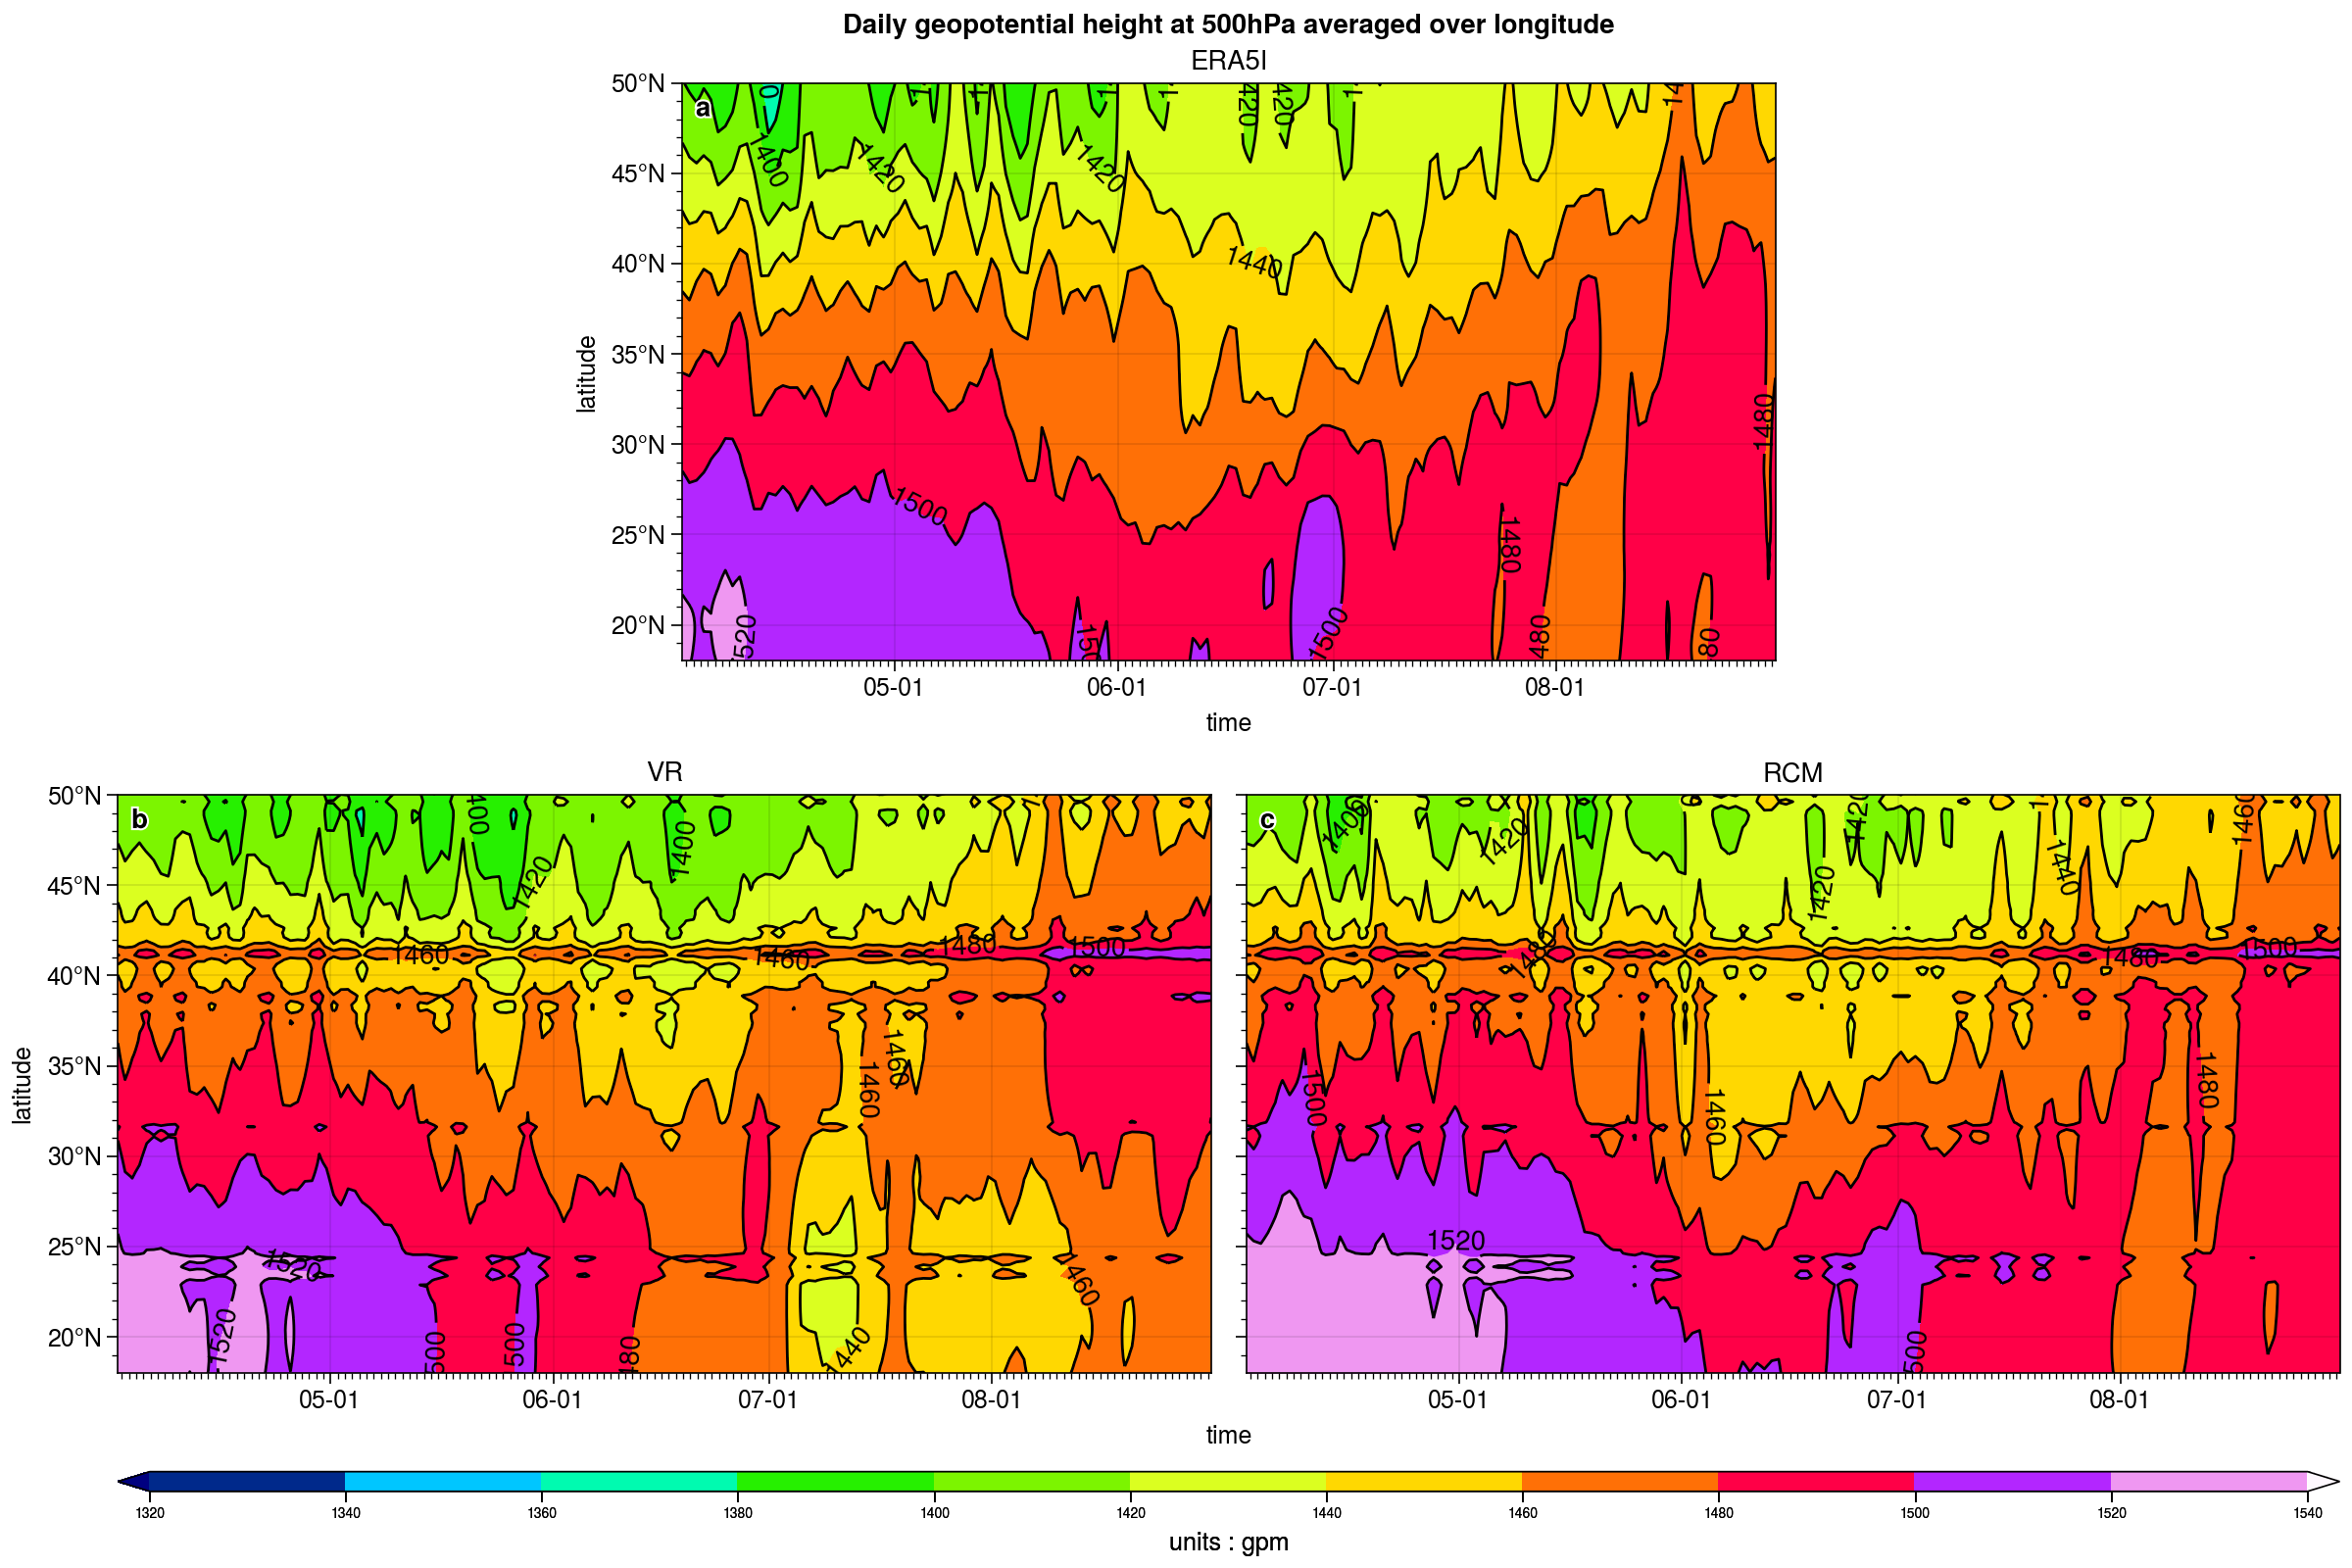

In [9]:
# import proplot as plot
from matplotlib import pyplot as plt
import proplot as plot
# ----- get filter vars coords-----

cmap="gist_ncar"
# cmap="tab20"
# cmap = "tab20b"

lat_sel  = var_lattime['era5i'].lat
# time_sel = var_lattime['cn051'].time.dt.strftime("%m-%d")
time_sel = var_lattime['era5i'].time.values
# 500hPa
# ticks = np.concatenate([np.arange(5300, 5700, 40), np.arange(5700, 5900, 10)])
# ticks_contour = np.arange(5800, 5920, 20)

# 850hPa
ticks = np.arange(1300, 1580, 20)
ticks_contour = np.arange(1300, 1580, 20)


#----- create plot -----
shape_array = [[0,1,1,0],[2,2,3,3]]
fig, axs = plot.subplots(shape_array,figsize=(12,8))

axs[0].format(title='ERA5I')
axs[1].format(title='VR')
axs[2].format(title='RCM')
# m = axs[0].contour(lon_sel, time_sel, var_lattime['cn051'],\
# levels=ticks,color='k',
# linewidth = .5)
for i, ivar in enumerate(var_list):
    m_overlay = axs[i].contourf(time_sel,  lat_sel, var_lattime[ivar].values.T, cmap=cmap,\
    levels=ticks)
    m_contour = axs[i].contour(time_sel,  lat_sel, var_lattime[ivar].values.T,\
    levels=ticks_contour,linewidth=1,color='k')
    axs[i].clabel(m_contour, inline=True, fontsize=10, colors = 'k', fmt='%4.0f',use_clabeltext=True, inline_spacing=0)
# format作为整个proplot集中对属性进行修改的method
axs.format(
xlocator=('month', [4,5,6,7,8]),
xminorlocator='day',
# xlocator='weekday',
xformatter='%m-%d',
yformatter='deglat',
xrotation=0,  # rotated time ticks
ylim=(18,50),
abc=True, abcloc='ul',
xlabel='time',
ylabel='latitude',
suptitle="Daily geopotential height at 500hPa averaged over longitude"
)

# for tick in axs.get_xticklabels():
    # tick.set_rotation(45)
#----- add contour tick labels -----
fig.colorbar(m_overlay, loc='b', length = 1., width=0.1,extend='both', label='units : gpm',
ticklabelsize=5,ticks=ticks)

fig.patch.set_facecolor('white')
plt.savefig('./output_pic/hgt_850_98-17_lat-time_py.png', dpi=600, facecolor= "white")